# Case7-challenge00_pix2wcs


Modified version from Case7-0challengef by T. Kamizuka. 

In this note, we estimate the field parameters and distortion parameters from the observed positions on the focal plane in the overlapped plates. We also use reference stars (Gaia stars) whose sky coordinates are known in a certain accuracy. The SIP-convention distortion is considered in this note.

## Preparation

First, we load the data.

In [1]:
import astropy.io.ascii as asc
import astropy.units as u

objects = asc.read('/Users/dkawata/work/obs/projs/JASMINE-Mission/analysis-testing-e2e/jasmine_warpfield/challenge/case7/case7_challenge_00.txt') #consists of x (um), y (um), catalog_id, ra (deg), dec (deg), and field.
pointings = asc.read('/Users/dkawata/work/obs/projs/JASMINE-Mission/analysis-testing-e2e/jasmine_warpfield/challenge/case7/case7_challenge_00_pointing.txt') # consists of field, ra (deg), dec (deg), and pa (deg).

We can convert the units of x and y from um to pix with assuming the pixel size to be 15 um. However, we will use um unit for the detector coordinates. The input data are created with Sip definition of crpix=[0,0] and origin=1, which map the origin to [0 um, 0 um].

In [2]:
pix_size = 15.*u.um
# objects['x'] = (objects['x']/pix_size).si
# objects['y'] = (objects['y']/pix_size).si
# objects: x (px), y (px), catalog_id, ra (deg), dec (deg), and field.
# pointings: field, ra (deg), dec (deg), and pa (deg).

Then, we change the ids for easy handling.

In [3]:
from astropy.table import unique
import numpy as np

ids = unique(objects, keys='catalog_id')['catalog_id']
objects.add_column(-1, name='id')
for i in range(0, np.size(ids)):
    pos = np.where(objects['catalog_id']==ids[i])
    objects['id'][pos] = i

objects.remove_column('catalog_id')
objects.rename_column('id', 'catalog_id')

Here, we make some arrays for further analysis. One new array is true_radec which stores true ra/dec values. Duplicated information (rows for the same object) is removed, and the rows are sorted with object ids. Another new array is observed_xy. It contains field ids, observed x/y positions on the focal plane, catalog ids. We rename ra, dec to ra_est, dec_est to store the estimated sky positions.

In [4]:
true_radec = objects['catalog_id', 'ra', 'dec'].copy()
true_radec.sort('catalog_id')
true_radec = unique(true_radec, keys='catalog_id') # consists of catalog_id, ra (deg), and dec (deg).

observed_xy = objects['field', 'x', 'y', 'catalog_id', 'ra', 'dec'].copy()
# observed_xy.rename_column('ra', 'ra_est')
# observed_xy.rename_column('dec', 'dec_est')
observed_xy.add_column(observed_xy['ra'], name='ra_est')
observed_xy.add_column(observed_xy['dec'],name='dec_est')
# observed_xy will have field, x (px), y (px), catalog_id, and estimated ra/dec (deg).

# initializing ra_est and dec_est
observed_xy['ra_est']  = 0.0
observed_xy['dec_est'] = 0.0

In addition, we make another array which stores field parameters. The plate scale is assumed to be the same value for all plates. At this time, an approximated value is stored in a variable (plate_scale).

In [5]:
field_params = pointings.copy() # field, ra (deg), dec (deg), and pa (deg).
true_field_params = field_params.copy()
# field_params['pa'] -= 240.0 # offset?
# plate_scale = 8.e-6*u.deg*(pix_size/u.um).si # in deg/pix
plate_scale = 8.e-6*u.deg/u.um
print(plate_scale)

8e-06 deg / um


Let's check the object distribution on sky.

Text(0, 0.5, 'dec (deg)')

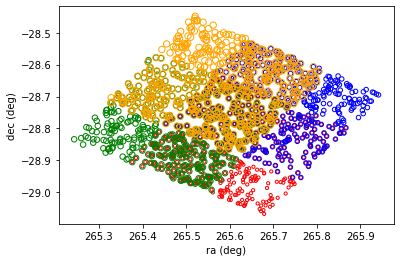

In [6]:
import matplotlib.pylab as plt
import numpy as np

color = ['red', 'blue', 'green', 'orange']

for i in range(0, np.max(field_params['field'])+1):
    pos = np.where(objects['field']==i)
    plt.scatter(objects['ra'][pos], objects['dec'][pos], marker='o', facecolor='None', edgecolor=color[i], s=10*i+10)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')

We can see that the data consists of four regions and that the overlapped region has a size of about a 1/4 FoV.

We select the objects in the overlapped region for further analysis.

In [7]:
true_radec_overlap = true_radec.copy()
observed_xy_overlap = observed_xy.copy()
for cid in true_radec['catalog_id']:
    if np.count_nonzero(observed_xy['catalog_id']==cid)!=4:
    # if np.count_nonzero(observed_xy['catalog_id']==cid)<=1:
        pos = np.where(true_radec_overlap['catalog_id']==cid)[0]
        true_radec_overlap.remove_rows(pos)
        pos = np.where(observed_xy_overlap['catalog_id']==cid)[0]
        observed_xy_overlap.remove_rows(pos)

Let's check the distribution of the selected objects.

225


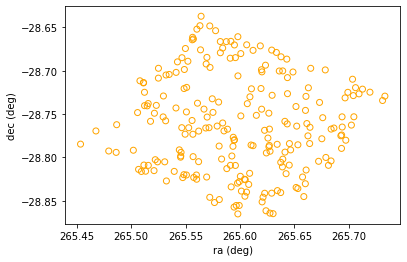

In [8]:
plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='o', facecolor='None', edgecolor='orange')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
print(len(true_radec_overlap['ra']))

These objects will be used for the following analysis.

We again modify the catalog id for easy handling.

In [9]:
ids = unique(true_radec_overlap, keys='catalog_id')['catalog_id']
true_radec_overlap.add_column(-1, name='id')
observed_xy_overlap.add_column(-1, name='id')
for i in range(0, np.size(ids)):
    pos = np.where(true_radec_overlap['catalog_id']==ids[i])
    true_radec_overlap['id'][pos] = i
    pos = np.where(observed_xy_overlap['catalog_id']==ids[i])
    observed_xy_overlap['id'][pos] = i

true_radec_overlap.remove_column('catalog_id')
true_radec_overlap.rename_column('id', 'catalog_id')
observed_xy_overlap.remove_column('catalog_id')
observed_xy_overlap.rename_column('id', 'catalog_id')

## First guess of the positions

At first, we define a wcs constructor.

In [10]:
from astropy.wcs import WCS
from astropy.wcs import Sip
import astropy.units as u

def wcs(ra_ptg, dec_ptg, pa_ptg, scale, a=None, b=None, ap=None, bp=None):
    w = WCS(naxis=2)
    w.wcs.crpix=[0,0]
    w.wcs.cdelt=np.array([-scale, scale])
    w.wcs.crval=[ra_ptg, dec_ptg]
    w.wcs.ctype=["RA---TAN-SIP", "DEC--TAN-SIP"]
    w.wcs.pc=[[ np.cos(pa_ptg*u.deg), -np.sin(pa_ptg*u.deg)],
              [np.sin(pa_ptg*u.deg), np.cos(pa_ptg*u.deg)]]
#    if a is not None and b is not None:
    w.sip = Sip(a, b, ap, bp, [0, 0])
    
    return w

Then, we estimate the sky coordinates from the observed focal-plane positions and (approximated) field parameters.

In [11]:
for i in range(0, np.size(field_params)):
    fp = field_params[i]
    w = wcs(fp['ra'], fp['dec'], fp['pa'], plate_scale.value)
    pos = np.where(observed_xy_overlap['field']==fp['field'])
    ret = w.all_pix2world(np.concatenate(([observed_xy_overlap[pos]['x']], [observed_xy_overlap[pos]['y']])).T, 0)
    observed_xy_overlap['ra_est'][pos]  = ret[:, 0]
    observed_xy_overlap['dec_est'][pos] = ret[:, 1]

Let's check the true positions and estimated positions.

 number of stars used = 900


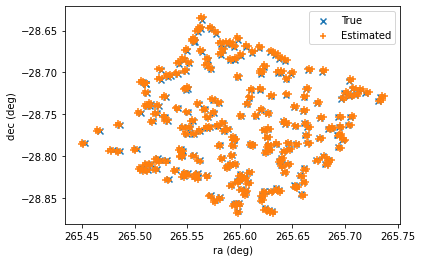

In [12]:
plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='x', label='True')
plt.scatter(observed_xy_overlap['ra_est'], observed_xy_overlap['dec_est'], marker='+', label='Estimated')
print(' number of stars used =', len(observed_xy_overlap['ra_est']))
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.legend()

Test for distortion with A/B, using the following c and d.

In [13]:
c = np.zeros(shape=(3, 3))
d = np.zeros(shape=(3, 3))

c[0,2]=-2.34153374723336e-09
c[1,1]=1.5792128155073916e-08
c[1,2]=7.674347291529089e-15
c[2,0]=-4.694743859349522e-09
c[2,1]=5.4256004358596465e-15
c[2,2]=-4.6341769281246224e-21
d[0,2]=-1.913280244657798e-08
d[1,1]=-5.622875292409728e-09
d[1,2]=-1.0128311203344238e-14
d[2,0]=3.1424733259527392e-09
d[2,1]=-9.08024075521211e-15
d[2,2]=-1.4123037013352912e-20

 diff ra=          ra_est        
          deg          
-----------------------
 1.8201350997060217e-05
   9.60581496656232e-06
 -7.802975517279265e-06
 -1.946410702657886e-05
-1.6551439671275148e-05
-1.3200699129356508e-05
  1.209157744597178e-06
-2.9153682135074632e-08
  1.622400435508098e-05
-1.4921175761628547e-06
                    ...
  -6.71867593382558e-06
-1.2957685498804494e-05
  2.920086785707099e-07
 2.3814620249140717e-06
  5.746174736032117e-06
  4.458012375607723e-05
 2.1436671090668824e-05
  3.407003384836571e-05
 4.9868886947024293e-05
  0.0001081956477833046
Length = 900 rows
 diff dec=         dec_est        
          deg          
-----------------------
 2.4965962222012195e-05
 1.3426362144741688e-05
-1.1419687783842392e-05
-2.8966534536323252e-05
 -2.477087401331346e-05
-1.9717471126057262e-05
 4.2073839523482093e-07
 -4.644613227355876e-08
  2.246222383561758e-05
-2.1995200860658315e-06
                    ...
  -9.18505586611218e-06
-1.8002651565041106e-05
 

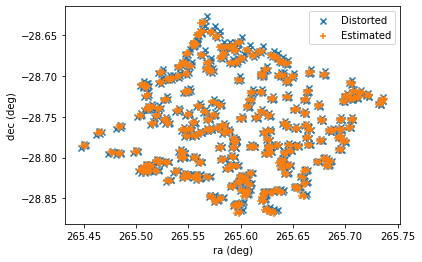

In [14]:
# print(observed_xy_overlap['ra_est'])
c *= 100.0
ra_dist = np.zeros_like(observed_xy_overlap['ra_est'])
dec_dist = np.zeros_like(observed_xy_overlap['dec_est'])

for i in range(0, np.size(field_params)):
    fp = field_params[i]
    w = wcs(fp['ra'], fp['dec'], fp['pa'], plate_scale.value, a=c, b=d)
    pos = np.where(observed_xy_overlap['field']==fp['field'])
    ret = w.all_pix2world(np.concatenate(([observed_xy_overlap[pos]['x']], [observed_xy_overlap[pos]['y']])).T, 0)
    ra_dist[pos] = ret[:,0]
    dec_dist[pos] = ret[:,1]
    
print(' diff ra=', ra_dist-observed_xy_overlap['ra_est'])
print(' diff dec=', dec_dist-observed_xy_overlap['dec_est'])

plt.scatter(ra_dist, dec_dist, marker='x', label='Distorted')
plt.scatter(observed_xy_overlap['ra_est'], observed_xy_overlap['dec_est'], marker='+', label='Estimated')
print(' number of stars used =', len(observed_xy_overlap['ra_est']))
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.legend()
    

Check if these stars cover the large enough detector region.

 number of all stars= 2574


Text(0, 0.5, 'y (pix)')

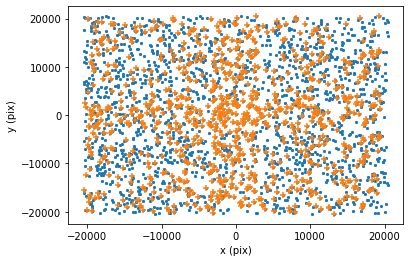

In [15]:
plt.scatter(objects['x'], objects['y'], marker='x', label='All', s=5)
print(' number of all stars=', len(objects['x']))
plt.scatter(observed_xy_overlap['x'], observed_xy_overlap['y'], marker='+', label='Overlap')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')


Here, there are four estimated positions for each object. We take their mean values as the first-guess positions and store them in radec_est array.

In [16]:
from astropy.table import Table

radec_est = Table(names=['catalog_id', 'ra_est', 'dec_est'], \
            dtype=['int64', 'float64', 'float64'])
#           units=[None, u.deg, u.deg], \
#           dtype=['int64', 'float64', 'float64'])

radec_est['ra_est'].unit = u.deg
radec_est['dec_est'].unit = u.deg

cat_ids = unique(observed_xy_overlap, 'catalog_id')['catalog_id']

for i in cat_ids:
    pos = np.where(observed_xy_overlap['catalog_id'] == i)
    ra = np.mean(observed_xy_overlap[pos]['ra_est'])*u.deg
    dec = np.mean(observed_xy_overlap[pos]['dec_est'])*u.deg
    radec_est.add_row([i, ra, dec])
    
# print('radec_est=', radec_est)


Let's check the estimated positions.

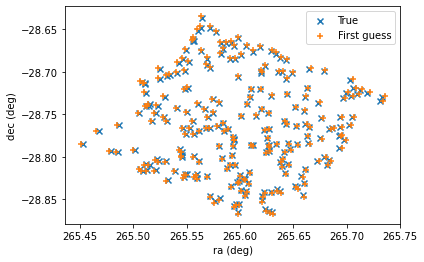

In [17]:
plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='x', label='True')
plt.scatter(radec_est['ra_est'], radec_est['dec_est'], marker='+', label='First guess')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.legend()

## Parameter adjustment

At first, we define a function which calculates x/y positions from the ra/dec values estimated above and the field/catalog ids.

In [18]:
def xy_calculator(observed_xy, field_params, plate_scale, ap, bp, radec_info):
    # observed_xy:  consists of field, x (px), y (px), catalog_id, ra_est (deg), and dec_est(deg).
    # field_params: consists of field, ra (deg), dec (deg), and pa (deg).
    # radec_info:   consists of catalog_id, ra_est (deg), and dec_est (deg).

    observed_xy_cp = observed_xy.copy()
    observed_xy_cp.rename_column('x', 'x_est')
    observed_xy_cp.rename_column('y', 'y_est')
    observed_xy_cp['x_est']   = None
    observed_xy_cp['y_est']   = None
    observed_xy_cp['ra_est']  = None
    observed_xy_cp['dec_est'] = None

    for i in range(0, np.size(radec_info)):
        pos = np.where(observed_xy_cp['catalog_id']==radec_info[i]['catalog_id'])
        observed_xy_cp['ra_est'][pos]  = radec_info[i]['ra_est']
        observed_xy_cp['dec_est'][pos] = radec_info[i]['dec_est']
    
    for i in range(0, np.size(field_params)):
        fp = field_params[i]
        w = wcs(fp['ra'], fp['dec'], fp['pa'], plate_scale, ap=ap, bp=bp)
        pos = np.where(observed_xy_cp['field']==fp['field'])
        radec0 = np.concatenate(([observed_xy_cp[pos]['ra_est']], [observed_xy_cp[pos]['dec_est']])).T
        ret = w.sip_foc2pix(w.wcs_world2pix(radec0, 1)-w.wcs.crpix, 1)
        observed_xy_cp['x_est'][pos] = ret[:, 0]
        observed_xy_cp['y_est'][pos] = ret[:, 1]

    return observed_xy_cp['x_est', 'y_est']

Next, we define a function to map from ra/dec to x/y, using A/B Sip distortion parameters. 

In [19]:
def radec_calculator_ab(observed_xy, field_params, plate_scale, a, b):
    # observed_xy:  consists of field, x (px), y (px), catalog_id, ra_est (deg), and dec_est(deg).
    # field_params: consists of field, ra (deg), dec (deg), and pa (deg).
    # radec_info:   consists of catalog_id, ra_est (deg), and dec_est (deg).

    
    observed_xy_cp = observed_xy.copy()
    # observed_xy_cp.rename_column('x', 'x_est')
    # observed_xy_cp.rename_column('y', 'y_est')
    # observed_xy_cp['x_est']   = None
    # observed_xy_cp['y_est']   = None
    observed_xy_cp['ra_est']  = None
    observed_xy_cp['dec_est'] = None
    
    for i in range(0, np.size(field_params)):
        fp = field_params[i]
        w = wcs(fp['ra'], fp['dec'], fp['pa'], plate_scale, a=a, b=b)
        pos = np.where(observed_xy_cp['field']==fp['field'])
        pix0 = np.concatenate(([observed_xy_cp[pos]['x']], [observed_xy_cp[pos]['y']])).T
        ret = w.all_pix2world(pix0, 1)
        # ret = w.sip_pix2foc(w.wcs_pix2world(pix0, 1)-w.wcs.crval, 1)
        observed_xy_cp['ra_est'][pos]  = ret[:, 0]
        observed_xy_cp['dec_est'][pos] = ret[:, 1]
    
    return observed_xy_cp['ra_est', 'dec_est']

### Using scipy.optimize least_squares, assuming the pointing sky coordinate, RA, DEC are accurately known.

Define model function to solve with Least Squares.

In [23]:
# def model_func(params, n_fields, dim_sip, observed_xy):
def model_func(params, ra_ptgs, dec_ptgs, n_fields, dim_sip, observed_xy):
    # params = (ra_ptgs, dec_ptgs, pa_ptg..., scale, a..., b...)
    pa_ptgs, scale, a, b =\
          np.split(params, [n_fields, n_fields+1,\
                          n_fields+1+(dim_sip+1)**2])
    # ra_ptgs, dec_ptgs, pa_ptgs, scale, a, b =\
    #    np.split(params, [n_fields, 2*n_fields, 3*n_fields, 3*n_fields+1,\
    #                      3*n_fields+1+(dim_sip+1)**2])

    field_params = Table(data=[ra_ptgs, dec_ptgs, pa_ptgs, -np.ones(shape=(np.size(ra_ptgs)))],\
                         names=['ra', 'dec', 'pa', 'field'],\
                         dtype=['float64', 'float64', 'float64', 'int64'])
#                         names=['ra', 'dec', 'pa', 'field'],\
#                         units=[u.deg, u.deg, u.deg, None],\
#                         dtype=['float64', 'float64', 'float64', 'int64'])
    field_params['ra'].unit = u.deg
    field_params['dec'].unit = u.deg
    field_params['pa'].unit = u.deg
    field_params['field'] = np.arange(0, np.size(field_params))
    
    # use copy of observed_xy
    observed_xy_cp = observed_xy.copy()
    
    a_matrix = np.reshape(a, (dim_sip+1, dim_sip+1))
    b_matrix = np.reshape(b, (dim_sip+1, dim_sip+1))
    
    # mns = np.concatenate(((0, 1), np.arange(dim_sip+1, 2*(dim_sip)+1))) 
    # for mn in mns:
    #    for m in range(np.max([0, mn-dim_sip]), np.min([mn+1, dim_sip+1])):
    #        n = mn - m
    #        ap_matrix[m, n] = 0
    #        bp_matrix[m, n] = 0
    a_matrix[0, 0] = 0.0
    a_matrix[0, 1] = 0.0
    a_matrix[1, 0] = 0.0
    b_matrix[0, 0] = 0.0
    b_matrix[0, 1] = 0.0
    b_matrix[1, 0] = 0.0

    m, n = np.indices((dim_sip+1, dim_sip+1))
    mn = m + n
    a_matrix = a_matrix * (1.e-3**mn)
    b_matrix = b_matrix * (1.e-3**mn)
    
    # compute ra/dec from x/y with the parameters.
    ret = radec_calculator_ab(observed_xy_cp, field_params, scale[0], \
                                                              a_matrix, b_matrix)
    
    observed_xy_cp['ra_est'] = ret['ra_est']
    observed_xy_cp['dec_est'] = ret['dec_est']
    
    # compute the mean ra/dec for unique stars
    cat_ids = unique(observed_xy_cp, 'catalog_id')['catalog_id']
    
    ra_mean = np.zeros_like(observed_xy_cp['ra_est'])
    dec_mean = np.zeros_like(observed_xy_cp['ra_est'])

    for i in cat_ids:
        pos = np.where(observed_xy_cp['catalog_id'] == i)
        ra_mean[pos] = np.mean(observed_xy_cp[pos]['ra_est'])*u.deg
        dec_mean[pos] = np.mean(observed_xy_cp[pos]['dec_est'])*u.deg
    

    radec_est = np.concatenate((observed_xy_cp['ra_est'], observed_xy_cp['dec_est']))
    radec_est_mean = np.concatenate((ra_mean, dec_mean))
    

    residuals = radec_est - radec_est_mean

    return residuals

Next, we execute the least-square calculation to derive the field parameters and sky positions of the objects in the overlapped region.

In [24]:
from scipy.optimize import least_squares
import time

dim_sip = 3
a = np.zeros(shape=(dim_sip+1, dim_sip+1))
b = np.zeros(shape=(dim_sip+1, dim_sip+1))

# constructing a_init (initial parameter set).
# a_init = np.array(np.concatenate((field_params['ra'], field_params['dec'], field_params['pa'], \
#                                   [plate_scale.value], a.flatten(), b.flatten()))) # This must be an ndarray.
a_init = np.array(np.concatenate((field_params['pa'], \
                                  [plate_scale.value], a.flatten(), b.flatten()))) # This must be an ndarray.
print(' # of fitting parameters =', len(a_init))
# constraining ra/dec values in 'observed' between -180 and 180 deg.
# measured = np.concatenate((observed_xy_overlap['x'], observed_xy_overlap['y']))
# print(' # of data points =', len(measured))
#pos = np.where(measured>180.)
#measured[pos] -= 360.
#pos = np.where(measured<-180.)
#measured[pos] += 360.

start = time.time()
# result = least_squares(model_func, a_init, loss='linear', args=(np.size(field_params), \
#                         dim_sip, observed_xy_overlap), \
#                       verbose=2)
result = least_squares(model_func, a_init, loss='linear', args=(field_params['ra'], \
                      field_params['dec'], np.size(field_params), dim_sip, observed_xy_overlap), \
                      verbose=2)
print(' time=',time.time()-start)

## pa should be a positive value between 0 and 360.
#if result[3] < 0:
#    result[3] = -result[3]
#    result[2] = result[2] + 180.0
#
#if result[2] > 360.0 or result[2] < 0.0:
#    result[2] = result[2]%360.0

 # of fitting parameters = 37
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7025e-03                                    2.25e+04    
       1              2         1.0097e-10      1.70e-03       6.04e+02       1.51e-01    
       2              3         1.7083e-15      1.01e-10       1.21e+03       3.01e-04    
       3              4         1.6973e-15      1.09e-17       2.42e+03       7.59e-08    
       4              5         1.6973e-15      7.46e-21       4.83e+03       1.69e-08    
       5              9         1.6973e-15      3.96e-21       1.51e+02       1.57e-09    
`gtol` termination condition is satisfied.
Function evaluations 9, initial cost 1.7025e-03, final cost 1.6973e-15, first-order optimality 1.57e-09.
 time= 15.75437307357788


### Checking results

#### Preparation

In [25]:
n_fields = np.size(field_params)
n_objects = np.size(radec_est)
true_ra_ptgs = true_field_params['ra'].data
true_dec_ptgs = true_field_params['dec'].data
true_pa_ptgs = true_field_params['pa'].data

# ra_ptgs, dec_ptgs, pa_ptgs, scale, a, b =\
#       np.split(result.x, [n_fields, 2*n_fields, 3*n_fields, 3*n_fields+1,\
#                           3*n_fields+1+(dim_sip+1)**2])
pa_ptgs, scale, a, b =\
       np.split(result.x, [n_fields, n_fields+1,\
                           n_fields+1+(dim_sip+1)**2])
ra_ptgs = field_params['ra'].data
dec_ptgs = field_params['dec'].data

a_matrix = np.reshape(a, (dim_sip+1, dim_sip+1))
b_matrix = np.reshape(b, (dim_sip+1, dim_sip+1))
# A/B scaling
m, n = np.indices((dim_sip+1, dim_sip+1))
mn = m + n
a_matrix = a_matrix * (1.e-3**mn)
b_matrix = b_matrix * (1.e-3**mn)

fit_field_params = Table(data=[ra_ptgs, dec_ptgs, pa_ptgs, -np.ones(shape=(np.size(ra_ptgs)))],\
                         names=['ra', 'dec', 'pa', 'field'],\
                         dtype=['float64', 'float64', 'float64', 'int64'])
fit_field_params['ra'].unit = u.deg
fit_field_params['dec'].unit = u.deg
fit_field_params['pa'].unit = u.deg
fit_field_params['field'] = np.arange(0, np.size(field_params))

#### Pointings

In [26]:
print(' pointing centre (fit) ra, dec (deg) =', ra_ptgs, dec_ptgs)
print(' pointing centre (true) ra, dec (deg) =', true_ra_ptgs, true_dec_ptgs)
print(' difference ra, dec (deg) =', ra_ptgs-true_ra_ptgs, dec_ptgs-true_dec_ptgs)

 pointing centre (fit) ra, dec (deg) = [265.62153148 265.6996346  265.48921727 265.57142097] [-28.85151127 -28.74179839 -28.78387164 -28.67029473]
 pointing centre (true) ra, dec (deg) = [265.62153148 265.6996346  265.48921727 265.57142097] [-28.85151127 -28.74179839 -28.78387164 -28.67029473]
 difference ra, dec (deg) = [0. 0. 0. 0.] [0. 0. 0. 0.]


#### Pointings position angles

In [27]:
print(' position angle (fit) (deg) =', pa_ptgs)
print(' position angle (true) (deg) =', true_pa_ptgs)
print(' difference =', pa_ptgs-true_pa_ptgs)

 position angle (fit) (deg) = [301.84900343 301.85335715 301.24465962 303.65627692]
 position angle (true) (deg) = [301.8490035  301.85335708 301.24465943 303.65627669]
 difference = [-6.69739961e-08  7.28200007e-08  1.96527026e-07  2.35288837e-07]


#### Scale (deg/pix)

In [28]:
scale

array([7.84873693e-06])

In [29]:
print(' true scale =',(1e-6/7.3/np.pi*180.0)*u.deg/u.um)
# print(' true scale =',(1e-6/7.3/np.pi*180.0)*u.deg*(pix_size/u.um).si)

 true scale = 7.848736919600318e-06 deg / um


#### A/B

In [30]:
print(' derived A/B matrices = ', a_matrix, b_matrix)

 derived A/B matrices =  [[ 0.00000000e+00  0.00000000e+00  2.34193044e-09  5.87179116e-17]
 [ 0.00000000e+00 -1.57921864e-08 -7.68574816e-15 -3.15783478e-10]
 [ 4.69525985e-09 -5.75024105e-15 -1.33298883e-10 -7.88169035e-13]
 [ 9.12523097e-17  9.54365786e-10  1.21772127e-12  8.08967308e-16]] [[ 0.00000000e+00  0.00000000e+00  1.91344663e-08  7.39982122e-16]
 [ 0.00000000e+00  5.62308047e-09  1.03203981e-14  2.38186469e-09]
 [-3.14084307e-09  9.11023776e-15 -1.90326267e-09 -9.65505315e-13]
 [-4.87115965e-17 -1.29212121e-09 -1.27115980e-12 -1.27216748e-15]]


#### Object positions

 field params=         ra                 dec                 pa         field
       deg                 deg                deg              
------------------ ------------------- ------------------ -----
265.62153148319356 -28.851511272277236  301.8490034341061     0
 265.6996346022487  -28.74179839183368  301.8533571499483     1
 265.4892172664734 -28.783871644305666 301.24465962219017     2
265.57142097465146  -28.67029473412515  303.6562769203355     3


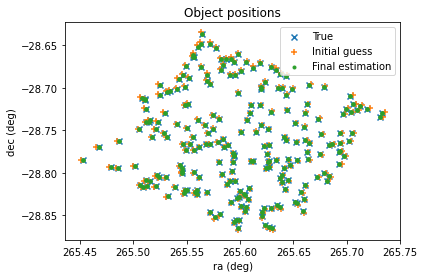

In [31]:
print(' field params=', fit_field_params)
radec_objs = radec_calculator_ab(observed_xy_overlap, fit_field_params, scale[0], a_matrix, b_matrix)

plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='x', label='True')
plt.scatter(radec_est['ra_est'], radec_est['dec_est'], marker='+', label='Initial guess')
plt.scatter(radec_objs['ra_est'], radec_objs['dec_est'], marker='.', label='Final estimation')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Object positions')
plt.legend()

#### Position difference

In [32]:
from astropy.coordinates import SkyCoord

distlist = []
print(np.shape(radec_objs))
for i in range(0, np.size(radec_objs)):
    c1 = SkyCoord(radec_objs['ra_est'][i]*u.deg, radec_objs['dec_est'][i]*u.deg)
    c2 = SkyCoord(observed_xy_overlap['ra'][i]*u.deg, observed_xy_overlap['dec'][i]*u.deg)
    distlist.append(c1.separation(c2).arcsec)
distlist = np.array(distlist)

(900,)


Text(0, 0.5, 'Number')

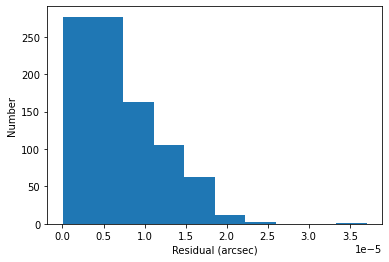

In [33]:
#plt.hist(np.log10(distlist))
plt.hist(distlist)
plt.xlabel("Residual (arcsec)")
plt.ylabel("Number")

Text(0, 0.5, 'dDEC (arcsec)')

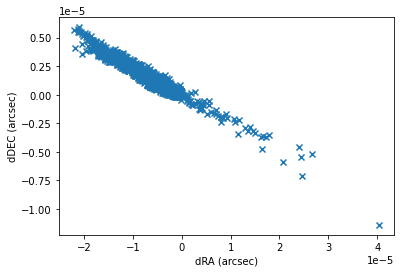

In [34]:
dra = ((radec_objs['ra_est']-observed_xy_overlap['ra']).data)*u.deg
ddec = ((radec_objs['dec_est']-observed_xy_overlap['dec']).data)*u.deg
dra_arcsec = dra.to_value(u.arcsec)
ddec_arcsec = ddec.to_value(u.arcsec)
plt.scatter(dra_arcsec, ddec_arcsec, marker='x')
plt.xlabel('dRA (arcsec)')
plt.ylabel('dDEC (arcsec)')
#plt.xlim([-0,8, 0.0])
#plt.ylim([-0.8, 0.0])

## Not fixing pointing RA, DEC, but use the reference stars. 

First, we define the model function to evaluate the difference in the sky coordinate of i-th stars, (ra, dec)i, from the individual plate, j-th plate, coordinates, (x, y)ij and the residual between (ra, dec)i and (ra, dec)k, for k-th reference stars whose (ra, dec)k is known from the other observation, e.g. Gaia.

In [35]:
def model_wrefs_func(params, n_fields, dim_sip, observed_xy, radec_refstars):
    # params = (ra_ptgs, dec_ptgs, pa_ptg..., scale, a..., b...)
    ra_ptgs, dec_ptgs, pa_ptgs, scale, a, b =\
        np.split(params, [n_fields, 2*n_fields, 3*n_fields, 3*n_fields+1,\
                          3*n_fields+1+(dim_sip+1)**2])

    field_params = Table(data=[ra_ptgs, dec_ptgs, pa_ptgs, -np.ones(shape=(np.size(ra_ptgs)))],\
                         names=['ra', 'dec', 'pa', 'field'],\
                         dtype=['float64', 'float64', 'float64', 'int64'])
#                         names=['ra', 'dec', 'pa', 'field'],\
#                         units=[u.deg, u.deg, u.deg, None],\
#                         dtype=['float64', 'float64', 'float64', 'int64'])
    field_params['ra'].unit = u.deg
    field_params['dec'].unit = u.deg
    field_params['pa'].unit = u.deg
    field_params['field'] = np.arange(0, np.size(field_params))
    
    # use copy of observed_xy
    observed_xy_cp = observed_xy.copy()
    
    a_matrix = np.reshape(a, (dim_sip+1, dim_sip+1))
    b_matrix = np.reshape(b, (dim_sip+1, dim_sip+1))
    
    # mns = np.concatenate(((0, 1), np.arange(dim_sip+1, 2*(dim_sip)+1))) 
    # for mn in mns:
    #    for m in range(np.max([0, mn-dim_sip]), np.min([mn+1, dim_sip+1])):
    #        n = mn - m
    #        ap_matrix[m, n] = 0
    #        bp_matrix[m, n] = 0
    a_matrix[0, 0] = 0.0
    a_matrix[0, 1] = 0.0
    a_matrix[1, 0] = 0.0
    b_matrix[0, 0] = 0.0
    b_matrix[0, 1] = 0.0
    b_matrix[1, 0] = 0.0

    # normalisation. 
    m, n = np.indices((dim_sip+1, dim_sip+1))
    mn = m + n
    a_matrix = a_matrix * (1.e-3**mn)
    b_matrix = b_matrix * (1.e-3**mn)
    
    # compute ra/dec from x/y with the parameters.
    ret = radec_calculator_ab(observed_xy_cp, field_params, scale[0], \
                                                              a_matrix, b_matrix)
    
    observed_xy_cp['ra_est'] = ret['ra_est']
    observed_xy_cp['dec_est'] = ret['dec_est']
    
    # compute the mean ra/dec for unique stars
    cat_ids = unique(observed_xy_cp, 'catalog_id')['catalog_id']
    
    ra_mean = np.zeros_like(observed_xy_cp['ra_est'])
    dec_mean = np.zeros_like(observed_xy_cp['ra_est'])

    for i in cat_ids:
        pos = np.where(observed_xy_cp['catalog_id'] == i)
        ra_mean[pos] = np.mean(observed_xy_cp[pos]['ra_est'])*u.deg
        dec_mean[pos] = np.mean(observed_xy_cp[pos]['dec_est'])*u.deg
        
    # reference stars' measured mean ra, dec to be compared 
    # with the ra, dec of reference stars. 
    radec_est_refstars = radec_refstars.copy()
    radec_est_refstars.rename_column('ra', 'ra_est')
    radec_est_refstars.rename_column('dec', 'dec_est')
    
    for i,id in enumerate(radec_refstars['catalog_id']):
      # print('i, id=', i, id)
      # print(ra_mean[observed_xy_cp['catalog_id'] == id][0])
      radec_est_refstars[i]['ra_est'] = ra_mean[observed_xy_cp['catalog_id'] == id][0]
      radec_est_refstars[i]['dec_est'] = dec_mean[observed_xy_cp['catalog_id'] == id][0]

    radec_est = np.concatenate((observed_xy_cp['ra_est'], observed_xy_cp['dec_est'], \
                              radec_refstars['ra'], radec_refstars['dec']))
    radec_est_mean = np.concatenate((ra_mean, dec_mean, radec_est_refstars['ra_est'], \
                                    radec_est_refstars['dec_est']))
    
    residuals = radec_est - radec_est_mean

    return residuals

Pick the reference stars from true_radec_overlap of overlap stars. 

In [36]:
# print(' true_radec_overlap =', true_radec_overlap)
print(' len =', len(true_radec_overlap))

# number of reference stars
n_refstars = 10
pos = np.random.choice(len(true_radec_overlap), size=n_refstars, replace=False)
radec_refstars = true_radec_overlap[pos]
print(radec_refstars)

 len = 225
        ra                 dec         catalog_id
       deg                 deg                   
------------------ ------------------- ----------
265.52304839747643 -28.739951680575917        129
  265.587401783301  -28.66634531700056        208
 265.6079469483813 -28.831201831705908         21
 265.5937726849388 -28.776769177089527        141
265.57898653177125 -28.763837110792796        151
265.62027655411555 -28.851371581939468          7
265.66493934481815 -28.697143318169438        171
265.62384224039073 -28.861621844986043          1
 265.5457885713645 -28.794172718888102        107
265.55991325203803 -28.820339475476317         92


Now, let's run least_squares and get the distortion parameters with the reference stars' constraints.

In [37]:
from scipy.optimize import least_squares
import time

dim_sip = 4
a = np.zeros(shape=(dim_sip+1, dim_sip+1))
b = np.zeros(shape=(dim_sip+1, dim_sip+1))

# constructing a_init (initial parameter set).
a_init = np.array(np.concatenate((field_params['ra'], field_params['dec'], \
                                  field_params['pa'], \
                                 [plate_scale.value], a.flatten(), b.flatten()))) # This must be an ndarray.
# a_init = np.array(np.concatenate((field_params['pa'], \
#                                  [plate_scale.value], a.flatten(), b.flatten()))) # This must be an ndarray.
print(' # of fitting parameters =', len(a_init))

print(' size of reference stars =', np.size(radec_refstars['catalog_id']))

start = time.time()
result = least_squares(model_wrefs_func, a_init, loss='linear', args= \
                       (np.size(field_params), dim_sip, observed_xy_overlap, \
                        radec_refstars), verbose=2)
print(' time=',time.time()-start)



 # of fitting parameters = 63
 size of reference stars = 10
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7130e-03                                    2.26e+04    
       1              2         1.0177e-10      1.71e-03       8.07e+02       1.48e-01    
       2              3         2.6915e-17      1.02e-10       1.61e+03       1.98e-04    
       3              4         9.9397e-22      2.69e-17       3.23e+03       2.34e-07    
       4              5         8.2123e-22      1.73e-22       6.45e+03       7.02e-08    
       5              7         5.7173e-22      2.50e-22       3.23e+03       3.82e-08    
       6              9         5.5555e-22      1.62e-23       1.61e+03       7.53e-08    
       7             11         5.4285e-22      1.27e-23       8.07e+02       9.05e-08    
       8             13         5.4149e-22      1.37e-24       4.03e+02       9.50e-08    
       9             15       

## Checking restuls
#### Preparation

In [39]:
n_fields = np.size(field_params)
n_objects = np.size(radec_est)
true_ra_ptgs = true_field_params['ra'].data
true_dec_ptgs = true_field_params['dec'].data
true_pa_ptgs = true_field_params['pa'].data

ra_ptgs, dec_ptgs, pa_ptgs, scale, a, b =\
       np.split(result.x, [n_fields, 2*n_fields, 3*n_fields, 3*n_fields+1,\
                           3*n_fields+1+(dim_sip+1)**2])
# pa_ptgs, scale, a, b =\
#       np.split(result.x, [n_fields, n_fields+1,\
#                           n_fields+1+(dim_sip+1)**2])
#ra_ptgs = field_params['ra'].data
# dec_ptgs = field_params['dec'].data

a_matrix = np.reshape(a, (dim_sip+1, dim_sip+1))
b_matrix = np.reshape(b, (dim_sip+1, dim_sip+1))
# A/B scaling
m, n = np.indices((dim_sip+1, dim_sip+1))
mn = m + n
a_matrix = a_matrix * (1.e-3**mn)
b_matrix = b_matrix * (1.e-3**mn)

fit_field_params = Table(data=[ra_ptgs, dec_ptgs, pa_ptgs, -np.ones(shape=(np.size(ra_ptgs)))],\
                         names=['ra', 'dec', 'pa', 'field'],\
                         dtype=['float64', 'float64', 'float64', 'int64'])
fit_field_params['ra'].unit = u.deg
fit_field_params['dec'].unit = u.deg
fit_field_params['pa'].unit = u.deg
fit_field_params['field'] = np.arange(0, np.size(field_params))

#### Pointings RA, DEC, position angle and scale

In [40]:
print(' pointing centre (fit) ra, dec (deg) =', ra_ptgs, dec_ptgs)
print(' pointing centre (true) ra, dec (deg) =', true_ra_ptgs, true_dec_ptgs)
print(' difference ra, dec (deg) =', ra_ptgs-true_ra_ptgs, dec_ptgs-true_dec_ptgs)
print(' position angle (fit) (deg) =', pa_ptgs)
print(' position angle (true) (deg) =', true_pa_ptgs)
print(' difference =', pa_ptgs-true_pa_ptgs)
print(' scale (fit, true) =', scale, (1e-6/7.3/np.pi*180.0)*u.deg/u.um)
print(' difference =', scale-(1e-6/7.3/np.pi*180.0))

 pointing centre (fit) ra, dec (deg) = [265.62153148 265.6996346  265.48921727 265.57142097] [-28.85151127 -28.74179839 -28.78387164 -28.67029473]
 pointing centre (true) ra, dec (deg) = [265.62153148 265.6996346  265.48921727 265.57142097] [-28.85151127 -28.74179839 -28.78387164 -28.67029473]
 difference ra, dec (deg) = [ 2.84217094e-13  1.70530257e-12 -1.47792889e-12 -5.11590770e-13] [-7.81597009e-14 -1.56674673e-12  8.27782287e-13 -5.08038056e-13]
 position angle (fit) (deg) = [301.8490035  301.85335708 301.24465942 303.65627669]
 position angle (true) (deg) = [301.8490035  301.85335708 301.24465943 303.65627669]
 difference = [ 2.79669621e-11  4.21732693e-09 -3.81851351e-09  3.52429197e-11]
 scale (fit, true) = [7.84873692e-06] 7.848736919600318e-06 deg / um
 difference = [-1.89769262e-17]


Object positions

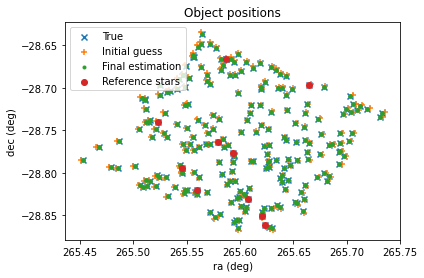

In [41]:
radec_objs = radec_calculator_ab(observed_xy_overlap, fit_field_params, scale[0], a_matrix, b_matrix)

plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='x', label='True')
plt.scatter(radec_est['ra_est'], radec_est['dec_est'], marker='+', label='Initial guess')
plt.scatter(radec_objs['ra_est'], radec_objs['dec_est'], marker='.', label='Final estimation')
plt.scatter(radec_refstars['ra'], radec_refstars['dec'], marker='o', \
            label='Reference stars')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Object positions')
plt.legend()

Position differences

(900,)


Text(0, 0.5, 'Number')

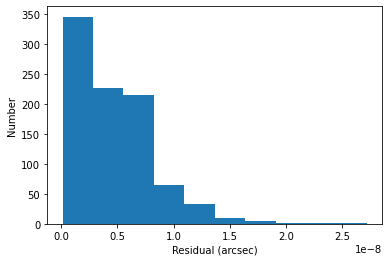

In [42]:
from astropy.coordinates import SkyCoord

distlist = []
print(np.shape(radec_objs))
for i in range(0, np.size(radec_objs)):
    c1 = SkyCoord(radec_objs['ra_est'][i]*u.deg, radec_objs['dec_est'][i]*u.deg)
    c2 = SkyCoord(observed_xy_overlap['ra'][i]*u.deg, observed_xy_overlap['dec'][i]*u.deg)
    distlist.append(c1.separation(c2).arcsec)
distlist = np.array(distlist)

#plt.hist(np.log10(distlist))
plt.hist(distlist)
plt.xlabel("Residual (arcsec)")
plt.ylabel("Number")

Text(0, 0.5, 'dDEC (arcsec)')

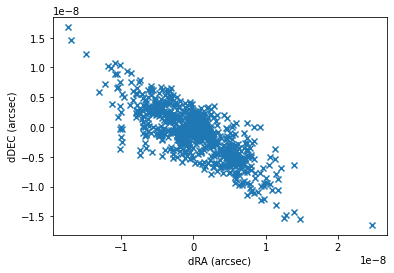

In [43]:
dra = ((radec_objs['ra_est']-observed_xy_overlap['ra']).data)*u.deg
ddec = ((radec_objs['dec_est']-observed_xy_overlap['dec']).data)*u.deg
dra_arcsec = dra.to_value(u.arcsec)
ddec_arcsec = ddec.to_value(u.arcsec)
plt.scatter(dra_arcsec, ddec_arcsec, marker='x')
plt.xlabel('dRA (arcsec)')
plt.ylabel('dDEC (arcsec)')
#plt.xlim([-0,8, 0.0])
#plt.ylim([-0.8, 0.0])

#### Apply the field parameters to all the objects.

 total # of stars = 2574


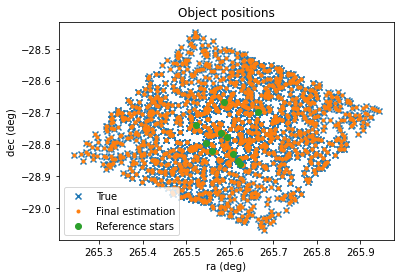

In [44]:
print(' total # of stars =', len(observed_xy))
radec_allobjs = radec_calculator_ab(observed_xy, fit_field_params, \
                                    scale[0], a_matrix, b_matrix)

plt.scatter(observed_xy['ra'], observed_xy['dec'], marker='x', label='True')
plt.scatter(radec_allobjs['ra_est'], radec_allobjs['dec_est'], marker='.', label='Final estimation')
plt.scatter(radec_refstars['ra'], radec_refstars['dec'], marker='o', \
            label='Reference stars')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Object positions')
plt.legend()

(2574,)


Text(0, 0.5, 'Number')

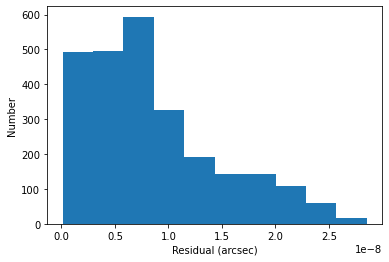

In [45]:
distlist = []
print(np.shape(radec_allobjs))
for i in range(0, np.size(radec_allobjs)):
    c1 = SkyCoord(radec_allobjs['ra_est'][i]*u.deg, radec_allobjs['dec_est'][i]*u.deg)
    c2 = SkyCoord(observed_xy['ra'][i]*u.deg, observed_xy['dec'][i]*u.deg)
    distlist.append(c1.separation(c2).arcsec)
distlist = np.array(distlist)

#plt.hist(np.log10(distlist))
plt.hist(distlist)
plt.xlabel("Residual (arcsec)")
plt.ylabel("Number")

Text(0, 0.5, 'dDEC (arcsec)')

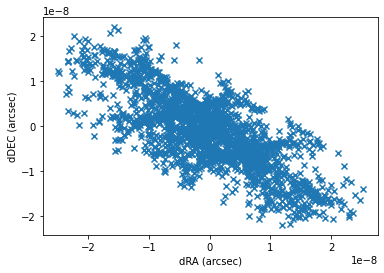

In [46]:
dra = ((radec_allobjs['ra_est']-observed_xy['ra']).data)*u.deg
ddec = ((radec_allobjs['dec_est']-observed_xy['dec']).data)*u.deg
dra_arcsec = dra.to_value(u.arcsec)
ddec_arcsec = ddec.to_value(u.arcsec)
plt.scatter(dra_arcsec, ddec_arcsec, marker='x')
plt.xlabel('dRA (arcsec)')
plt.ylabel('dDEC (arcsec)')
#plt.xlim([-0,8, 0.0])
#plt.ylim([-0.8, 0.0])

## With observatioal errors.

We add the observational errors for both JASMINE observations and reference stars, Gaia stars. We first add the position error + displacement for observed_xy_overlap. Then, later we will add the noise to observed_xy (all observations). The displacement for the same observation of stars should be the same between observed_xy and observed_xy_overlap. However, for now for the simplification of set up, we use independent one.

In [89]:
# JASMINE pixel position uncertainty, let's set to 1/300 pix
pix_size = 15.*u.um
xy_error_jasmine = (1.0/300)*pix_size
print(' JASMINE pix error (um) =', xy_error_jasmine)
# Reference stars ra, dec error, let's set to 0.02 mas
radec_error_refstars = (0.2*u.mas).to(u.deg)
print(' Reference stars error (deg) =', radec_error_refstars)

 JASMINE pix error (um) = 0.05 um
 Reference stars error (deg) = 5.555555555555557e-08 deg


In [60]:
# add errors to JASMINE pix position
# for overlap stars
observed_xy_overlap.rename_column('x', 'x0')
observed_xy_overlap.rename_column('y', 'y0')
observed_xy_overlap.add_column(observed_xy_overlap['x0'], name='x')
observed_xy_overlap.add_column(observed_xy_overlap['x0'], name='y')

observed_xy_overlap['x'] = np.random.normal(observed_xy_overlap['x0'], xy_error_jasmine)
observed_xy_overlap['y'] = np.random.normal(observed_xy_overlap['y0'], xy_error_jasmine)
# store the noise
observed_xy_overlap.add_column(observed_xy_overlap['x'], name='xy_err')

In [90]:
observed_xy_overlap['xy_err'] = xy_error_jasmine

In [62]:
# for all stars
observed_xy.rename_column('x', 'x0')
observed_xy.rename_column('y', 'y0')
observed_xy.add_column(observed_xy['x0'], name='x')
observed_xy.add_column(observed_xy['x0'], name='yt')

observed_xy['x'] = np.random.normal(observed_xy['x0'], xy_error_jasmine)
observed_xy['y'] = np.random.normal(observed_xy['y0'], xy_error_jasmine)
observed_xy.add_column(observed_xy['x'], name='xy_err')

In [91]:
observed_xy['xy_err'] = xy_error_jasmine

In [63]:
# add errors to reference stars
radec_refstars.rename_column('ra', 'ra0')
radec_refstars.rename_column('dec', 'dec0')
radec_refstars.add_column(radec_refstars['ra0'], name='ra')
radec_refstars.add_column(radec_refstars['dec0'], name='dec')


# print(' ra before noise =', radec_refstars['ra'])
radec_refstars['ra'] = np.random.normal(radec_refstars['ra0'], radec_error_refstars)
radec_refstars['dec'] = np.random.normal(radec_refstars['dec0'], radec_error_refstars)
# print(' ra w/added noise =', radec_refstars['ra'].to_value(u.mas))
# store the noise
radec_refstars.add_column(radec_refstars['ra'], name='radec_err')

In [92]:
radec_refstars['radec_err'] = radec_error_refstars

In [100]:
def model_wrefs_werr_func(params, n_fields, dim_sip, observed_xy, radec_refstars):
    # params = (ra_ptgs, dec_ptgs, pa_ptg..., scale, a..., b...)
    ra_ptgs, dec_ptgs, pa_ptgs, scale, a, b =\
        np.split(params, [n_fields, 2*n_fields, 3*n_fields, 3*n_fields+1,\
                          3*n_fields+1+(dim_sip+1)**2])

    field_params = Table(data=[ra_ptgs, dec_ptgs, pa_ptgs, -np.ones(shape=(np.size(ra_ptgs)))],\
                         names=['ra', 'dec', 'pa', 'field'],\
                         dtype=['float64', 'float64', 'float64', 'int64'])
#                         names=['ra', 'dec', 'pa', 'field'],\
#                         units=[u.deg, u.deg, u.deg, None],\
#                         dtype=['float64', 'float64', 'float64', 'int64'])
    field_params['ra'].unit = u.deg
    field_params['dec'].unit = u.deg
    field_params['pa'].unit = u.deg
    field_params['field'] = np.arange(0, np.size(field_params))
    
    # use copy of observed_xy
    observed_xy_cp = observed_xy.copy()
    
    a_matrix = np.reshape(a, (dim_sip+1, dim_sip+1))
    b_matrix = np.reshape(b, (dim_sip+1, dim_sip+1))
    
    # mns = np.concatenate(((0, 1), np.arange(dim_sip+1, 2*(dim_sip)+1))) 
    # for mn in mns:
    #    for m in range(np.max([0, mn-dim_sip]), np.min([mn+1, dim_sip+1])):
    #        n = mn - m
    #        ap_matrix[m, n] = 0
    #        bp_matrix[m, n] = 0
    a_matrix[0, 0] = 0.0
    a_matrix[0, 1] = 0.0
    a_matrix[1, 0] = 0.0
    b_matrix[0, 0] = 0.0
    b_matrix[0, 1] = 0.0
    b_matrix[1, 0] = 0.0

    # normalisation. 
    m, n = np.indices((dim_sip+1, dim_sip+1))
    mn = m + n
    a_matrix = a_matrix * (1.e-3**mn)
    b_matrix = b_matrix * (1.e-3**mn)
    
    # compute ra/dec from x/y with the parameters.
    ret = radec_calculator_ab(observed_xy_cp, field_params, scale[0], \
                                                              a_matrix, b_matrix)
    
    observed_xy_cp['ra_est'] = ret['ra_est']
    observed_xy_cp['dec_est'] = ret['dec_est']
    
    # compute the mean ra/dec for unique stars
    cat_ids = unique(observed_xy_cp, 'catalog_id')['catalog_id']
    
    ra_mean = np.zeros_like(observed_xy_cp['ra_est'])
    dec_mean = np.zeros_like(observed_xy_cp['dec_est'])
    # compute weights from error in xy (um) -> radec (deg)
    w_observed_xy = 1.0/(observed_xy_cp['xy_err']*scale[0])

    for i in cat_ids:
        pos = np.where(observed_xy_cp['catalog_id'] == i)
        ra_mean[pos] = np.average(observed_xy_cp[pos]['ra_est'], \
                                 weights=w_observed_xy[pos])*u.deg
        dec_mean[pos] = np.average(observed_xy_cp[pos]['dec_est'], \
                                 weights=w_observed_xy[pos])*u.deg
        
    # reference stars' measured mean ra, dec to be compared 
    # with the ra, dec of reference stars. 
    radec_est_refstars = radec_refstars.copy()
    radec_est_refstars.rename_column('ra', 'ra_est')
    radec_est_refstars.rename_column('dec', 'dec_est')
    # compute weights for reference stars
    w_refstars = 1.0/(radec_refstars['radec_err'])
    
    for i,id in enumerate(radec_refstars['catalog_id']):
      # print('i, id=', i, id)
      # print(ra_mean[observed_xy_cp['catalog_id'] == id][0])
      radec_est_refstars[i]['ra_est'] = ra_mean[observed_xy_cp['catalog_id'] == id][0]
      radec_est_refstars[i]['dec_est'] = dec_mean[observed_xy_cp['catalog_id'] == id][0]

    radec_est = np.concatenate((observed_xy_cp['ra_est'], observed_xy_cp['dec_est'], \
                              radec_refstars['ra'], radec_refstars['dec']))
    radec_est_mean = np.concatenate((ra_mean, dec_mean, radec_est_refstars['ra_est'], \
                                    radec_est_refstars['dec_est']))
    w_all = np.concatenate((w_observed_xy, w_observed_xy, w_refstars, w_refstars))
    
    residuals = w_all*(radec_est - radec_est_mean)

    return residuals

Let's run least squares. 

In [129]:
from scipy.optimize import least_squares
from scipy.optimize import leastsq
import time

dim_sip = 4
a = np.zeros(shape=(dim_sip+1, dim_sip+1))
b = np.zeros(shape=(dim_sip+1, dim_sip+1))

# constructing a_init (initial parameter set).
a_init = np.array(np.concatenate((field_params['ra'], field_params['dec'], \
                                  field_params['pa'], \
                                 [plate_scale.value], a.flatten(), b.flatten()))) # This must be an ndarray.
# a_init = np.array(np.concatenate((field_params['pa'], \
#                                  [plate_scale.value], a.flatten(), b.flatten()))) # This must be an ndarray.
print(' # of fitting parameters =', len(a_init))

print(' size of reference stars =', np.size(radec_refstars['catalog_id']))

start = time.time()
result = least_squares(model_wrefs_werr_func, a_init, loss='linear', args= \
                        (np.size(field_params), dim_sip, observed_xy_overlap, \
                        radec_refstars), verbose=2)
# result = least_squares(model_wrefs_werr_func, a_init, args= \
#                       (np.size(field_params), dim_sip, observed_xy_overlap, \
#                        radec_refstars))
print(' time=',time.time()-start)




 # of fitting parameters = 63
 size of reference stars = 10
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.4461e+03                                    5.82e+10    
       1              2         4.6626e-01      4.45e+03       8.07e+02       5.94e+08    
       2              3         2.8675e-04      4.66e-01       1.61e+03       9.28e+02    
       3             18         2.8675e-04      0.00e+00       0.00e+00       9.28e+02    
`xtol` termination condition is satisfied.
Function evaluations 18, initial cost 4.4461e+03, final cost 2.8675e-04, first-order optimality 9.28e+02.
 time= 22.03373408317566


## Checking results

Extract the results.

In [130]:
n_fields = np.size(field_params)
n_objects = np.size(radec_est)
true_ra_ptgs = true_field_params['ra'].data
true_dec_ptgs = true_field_params['dec'].data
true_pa_ptgs = true_field_params['pa'].data

ra_ptgs, dec_ptgs, pa_ptgs, scale, a, b =\
       np.split(result.x, [n_fields, 2*n_fields, 3*n_fields, 3*n_fields+1,\
                           3*n_fields+1+(dim_sip+1)**2])
# pa_ptgs, scale, a, b =\
#       np.split(result.x, [n_fields, n_fields+1,\
#                           n_fields+1+(dim_sip+1)**2])
#ra_ptgs = field_params['ra'].data
# dec_ptgs = field_params['dec'].data

print(' a and b matrices before scaling=', a, b)

a_matrix = np.reshape(a, (dim_sip+1, dim_sip+1))
b_matrix = np.reshape(b, (dim_sip+1, dim_sip+1))
# A/B scaling
m, n = np.indices((dim_sip+1, dim_sip+1))
mn = m + n
a_matrix = a_matrix * (1.e-3**mn)
b_matrix = b_matrix * (1.e-3**mn)

fit_field_params = Table(data=[ra_ptgs, dec_ptgs, pa_ptgs, -np.ones(shape=(np.size(ra_ptgs)))],\
                         names=['ra', 'dec', 'pa', 'field'],\
                         dtype=['float64', 'float64', 'float64', 'int64'])
fit_field_params['ra'].unit = u.deg
fit_field_params['dec'].unit = u.deg
fit_field_params['pa'].unit = u.deg
fit_field_params['field'] = np.arange(0, np.size(field_params))

 a and b matrices before scaling= [ 0.00000000e+00  0.00000000e+00  2.32240177e-03  4.04466359e-07
  7.95842158e-08  0.00000000e+00 -1.57981581e-02 -6.68222385e-06
  1.16349384e-07  4.26272068e+02  4.64168247e-03 -6.29693970e-06
  1.18259402e-07 -4.13436091e+02 -5.72783101e+02  3.76771568e-06
  8.07671241e-08 -3.38261394e+02 -3.43020186e+02  3.76485038e+02
  1.35083929e-07 -3.83940545e+02 -4.78607494e+01  4.76880470e+02
  4.58528380e+02] [ 0.00000000e+00  0.00000000e+00  1.90903092e-02  2.25357065e-06
  1.40095647e-07  0.00000000e+00  5.70428681e-03  9.89218507e-06
 -1.93330856e-07 -3.64042568e+02 -3.20955589e-03  7.37390849e-06
  2.13930587e-08  1.84525425e+02 -1.23404787e+02  9.43062099e-07
 -1.82625627e-07 -1.45139777e+02  2.93671928e+02  2.52515142e+02
  1.52066688e-07 -7.93927367e+02 -6.46590032e+02 -4.76414674e+02
 -2.43763511e+02]


Evaluate fitting. We follow https://www.fixes.pub/program/444521.html.

In [136]:
from scipy import linalg, optimize

chi2dof= np.sum(result.fun**2)/(result.fun.size -result.x.size)
print(' Xi^2/dof =', chi2dof)

J= result.jac
print(' shape of J =', np.shape(J))
# this does not work.
# cov= np.linalg.inv(J.T.dot(J))
# var= np.sqrt(np.diagonal(cov))
# print(' parameter variances =', var)

U, s, Vh= linalg.svd(result.jac, full_matrices=False)
tol= np.finfo(float).eps*s[0]*max(result.jac.shape)
w= s > tol
cov= (Vh[w].T/s[w]**2) @ Vh[w]  # robust covariance matrix
cov *= chi2dof
perr= np.sqrt(np.diag(cov))     # 1sigma uncertainty on fitted parameters

# extract errors

ra_ptgs_err, dec_ptgs_err, pa_ptgs_err, scale_err, a_err, b_err =\
       np.split(perr, [n_fields, 2*n_fields, 3*n_fields, 3*n_fields+1,\
                           3*n_fields+1+(dim_sip+1)**2])

# A/B scaling
a_err_matrix = np.reshape(a_err, (dim_sip+1, dim_sip+1))
b_err_matrix = np.reshape(b_err, (dim_sip+1, dim_sip+1))
# A/B scaling
m, n = np.indices((dim_sip+1, dim_sip+1))
mn = m + n
a_err_matrix = a_err_matrix * (1.e-3**mn)
b_err_matrix = b_err_matrix * (1.e-3**mn)

print(' parameter values =', ra_ptgs, dec_ptgs, pa_ptgs, scale, a_matrix, b_matrix)
print(' parameter variances =', ra_ptgs_err, dec_ptgs_err, pa_ptgs_err, scale_err, \
     a_err_matrix, b_err_matrix)

 Xi^2/dof = 3.2640403856117155e-07
 shape of J = (1820, 63)
 parameter values = [265.62153146 265.69963454 265.48921737 265.57142109] [-28.85151126 -28.74179853 -28.78387165 -28.67029487] [301.84897921 301.8534038  301.244655   303.65631209] [7.84872669e-06] [[ 0.00000000e+00  0.00000000e+00  2.32240177e-09  4.04466359e-16
   7.95842158e-20]
 [ 0.00000000e+00 -1.57981581e-08 -6.68222385e-15  1.16349384e-19
   4.26272068e-13]
 [ 4.64168247e-09 -6.29693970e-15  1.18259402e-19 -4.13436091e-13
  -5.72783101e-16]
 [ 3.76771568e-15  8.07671241e-20 -3.38261394e-13 -3.43020186e-16
   3.76485038e-19]
 [ 1.35083929e-19 -3.83940545e-13 -4.78607494e-17  4.76880470e-19
   4.58528380e-22]] [[ 0.00000000e+00  0.00000000e+00  1.90903092e-08  2.25357065e-15
   1.40095647e-19]
 [ 0.00000000e+00  5.70428681e-09  9.89218507e-15 -1.93330856e-19
  -3.64042568e-13]
 [-3.20955589e-09  7.37390849e-15  2.13930587e-20  1.84525425e-13
  -1.23404787e-16]
 [ 9.43062099e-16 -1.82625627e-19 -1.45139777e-13  2.9367192

#### Pointings RA, DEC, position angle and scale

In [137]:
print(' pointing centre (fit) ra, dec (deg) =', ra_ptgs, dec_ptgs)
print(' pointing centre (true) ra, dec (deg) =', true_ra_ptgs, true_dec_ptgs)
print(' difference ra, dec (deg) =', ra_ptgs-true_ra_ptgs, dec_ptgs-true_dec_ptgs)
print(' uncertainty ra, dec pointings =', ra_ptgs_err, dec_ptgs_err)

 pointing centre (fit) ra, dec (deg) = [265.62153146 265.69963454 265.48921737 265.57142109] [-28.85151126 -28.74179853 -28.78387165 -28.67029487]
 pointing centre (true) ra, dec (deg) = [265.62153148 265.6996346  265.48921727 265.57142097] [-28.85151127 -28.74179839 -28.78387164 -28.67029473]
 difference ra, dec (deg) = [-2.05846504e-08 -6.13014208e-08  1.04313074e-07  1.18344985e-07] [ 1.69855987e-08 -1.37144664e-07 -6.92337210e-09 -1.34996490e-07]
 uncertainty ra, dec pointings = [7.75121485e-08 9.73423809e-08 9.06371455e-08 9.36664427e-08] [7.22466261e-08 8.92907208e-08 8.57767398e-08 8.76589736e-08]


In [138]:
print(' position angle (fit) (deg) =', pa_ptgs)
print(' position angle (true) (deg) =', true_pa_ptgs)
print(' difference =', pa_ptgs-true_pa_ptgs)
print(' uncertainty =', pa_ptgs_err)

 position angle (fit) (deg) = [301.84897921 301.8534038  301.244655   303.65631209]
 position angle (true) (deg) = [301.8490035  301.85335708 301.24465943 303.65627669]
 difference = [-2.42914547e-05  4.67247898e-05 -4.42209961e-06  3.54025896e-05]
 uncertainty = [4.78716950e-05 4.53257876e-05 4.59879375e-05 4.96911791e-05]


In [140]:
print(' scale (fit, true) =', scale, (1e-6/7.3/np.pi*180.0)*u.deg/u.um)
print(' difference =', scale-(1e-6/7.3/np.pi*180.0))
print(' uncertainty =', scale_err)

 scale (fit, true) = [7.84872669e-06] 7.848736919600318e-06 deg / um
 difference = [-1.02287843e-11]
 uncertainty = [5.33444032e-12]


#### Objects positions

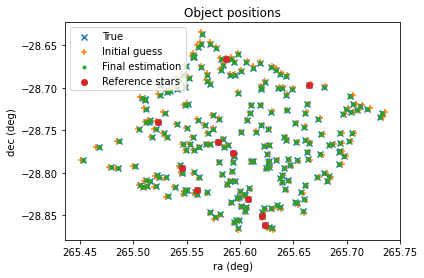

In [114]:
radec_objs = radec_calculator_ab(observed_xy_overlap, fit_field_params, scale[0], a_matrix, b_matrix)

plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='x', label='True')
plt.scatter(radec_est['ra_est'], radec_est['dec_est'], marker='+', label='Initial guess')
plt.scatter(radec_objs['ra_est'], radec_objs['dec_est'], marker='.', label='Final estimation')
plt.scatter(radec_refstars['ra0'], radec_refstars['dec0'], marker='o', \
            label='Reference stars')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Object positions')
plt.legend()

(900,)


Text(0, 0.5, 'Number')

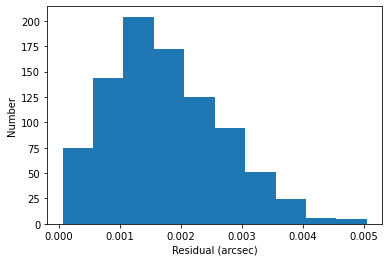

In [115]:
distlist = []
print(np.shape(radec_objs))
for i in range(0, np.size(radec_objs)):
    c1 = SkyCoord(radec_objs['ra_est'][i]*u.deg, radec_objs['dec_est'][i]*u.deg)
    c2 = SkyCoord(observed_xy_overlap['ra'][i]*u.deg, observed_xy_overlap['dec'][i]*u.deg)
    distlist.append(c1.separation(c2).arcsec)
distlist = np.array(distlist)

#plt.hist(np.log10(distlist))
plt.hist(distlist)
plt.xlabel("Residual (arcsec)")
plt.ylabel("Number")

Text(0, 0.5, 'dDEC (arcsec)')

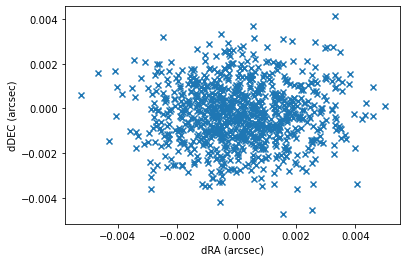

In [116]:
dra = ((radec_objs['ra_est']-observed_xy_overlap['ra']).data)*u.deg
ddec = ((radec_objs['dec_est']-observed_xy_overlap['dec']).data)*u.deg
dra_arcsec = dra.to_value(u.arcsec)
ddec_arcsec = ddec.to_value(u.arcsec)
plt.scatter(dra_arcsec, ddec_arcsec, marker='x')
plt.xlabel('dRA (arcsec)')
plt.ylabel('dDEC (arcsec)')

#### Apply to all the data, taking into account uncertainties of their position and parameter uncertainties.

We shall run Monte Carlo by randomly displacing the position of stars and distortion parameters.